# Analyse de Grille Hamiltonienne et Recherche de Chemin Quantique

## Aperçu
Ce notebook démontre l'analyse d'un réseau de grille Hamiltonienne avec des propriétés mécaniques quantiques. Il inclut :
- Initialisation du réseau avec des points d'entrée et de sortie configurables
- Propagation d'état quantique et calculs de fonction d'onde
- Analyse de résistance effective
- Identification du chemin le plus court en utilisant la pondération quantique
- Visualisation des distributions d'états quantiques à travers le réseau

## Composants Clés
- **HamiltonianGrid** : Une structure de graphe personnalisée qui implémente la mécanique quantique sur un réseau
- **Visualisation de Réseau** : Représentations interactives et statiques du réseau
- **Analyse Quantique** : Calcul des fonctions d'onde, résistances effectives et poids quantiques

In [1]:
# Importation des Bibliothèques Requises
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from utils import HamiltonianGrid

from pyvis.network import Network
from networkx.readwrite import json_graph
import json

# Ces importations fournissent :
# - numpy : calculs numériques et tableaux
# - networkx : structure de graphe et algorithmes
# - matplotlib : visualisations statiques
# - HamiltonianGrid : implémentation personnalisée de réseau quantique
# - pyvis : visualisations de réseau interactives

In [2]:
import plotly.graph_objects as go
import numpy as np

def plot_grid_plotly(G, psi_dict=None, line_width_scale=3, node_size=8, pos_scale=1, colorscale='Viridis', draw_buses=True):
    """
    Scientific Plotly visualization for HamiltonianGrid with colorbar.
    
    - Bus Nodes: Circles with color gradient based on |ψ|
    - Line Nodes: Diamonds with color gradient based on |ψ|  
    - Injection/Extraction: Star and Square markers
    - Edges: Width scaled by |ψ| (subtle)
    - Colorbar: Shows ψ magnitude scale
    """
    
    # Get psi values
    if psi_dict is None:
        psi_dict = {n: G.nodes[n].get('weight', 0) for n in G.nodes()}
    
    # Normalize psi values
    all_psi = [abs(psi_dict.get(n, 0)) for n in G.nodes()]
    max_psi = max(all_psi) if all_psi and max(all_psi) > 0 else 1
    min_psi = min(all_psi)
    
    # 1. EDGES - binned by psi, subtle width variation
    num_bins = 10
    bins = {i: {'x': [], 'y': [], 
                'width': 0.5 + (i/num_bins) * line_width_scale,
                'color': f'rgba(150,150,150,{0.2 + 0.4*(i/num_bins)})'
               } for i in range(num_bins + 1)}
    
    for u, v in G.edges():
        line_node = u if G.nodes[u].get('type') == 'line' else v if G.nodes[v].get('type') == 'line' else None
        psi_val = abs(psi_dict.get(line_node, 0)) if line_node else 0
        norm_psi = psi_val / max_psi if max_psi > 0 else 0
        bin_idx = min(int(norm_psi * num_bins), num_bins)
        
        x0, y0 = G.nodes[u]['pos']
        x1, y1 = G.nodes[v]['pos']
        bins[bin_idx]['x'].extend([x0, x1, None])
        bins[bin_idx]['y'].extend([y0, y1, None])
    
    edge_traces = [go.Scatter(
        x=b['x'], y=b['y'], mode='lines',
        line=dict(width=b['width'], color=b['color']),
        hoverinfo='none', showlegend=False
    ) for b in bins.values() if b['x']]
    
    # 2. COLLECT NODE DATA
    inject_node = f"N_{G.ix}_{G.iy}"
    extract_node = f"N_{G.ex}_{G.ey}"
    
    bus_x, bus_y, bus_psi, bus_text = [], [], [], []
    line_x, line_y, line_psi, line_text = [], [], [], []
    inject_x, inject_y, inject_text = [], [], []
    extract_x, extract_y, extract_text = [], [], []
    symbols = []
    
    for node, data in G.nodes(data=True):
        x, y = data['pos']
        x = x * pos_scale
        y = y * pos_scale
        psi_val = psi_dict.get(node, 0)
        
        if data.get('type') == 'node':
            if node == inject_node:
                inject_x.append(x); inject_y.append(y)
                inject_text.append(f"<b>SOURCE</b><br>{node}<br>ψ = {psi_val:.4f}")
            elif node == extract_node:
                extract_x.append(x); extract_y.append(y)
                extract_text.append(f"<b>SINK</b><br>{node}<br>ψ = {psi_val:.4f}")
            else:
                bus_x.append(x); bus_y.append(y)
                bus_psi.append(abs(psi_val))
                bus_text.append(f"Bus: {node}<br>ψ = {psi_val:.4f}")
        
        elif data.get('type') == 'line':
            if node.startswith("L_h"):
                symbols.append('diamond-wide')
            else:
                symbols.append('diamond-tall')
            line_x.append(x); line_y.append(y)
            line_psi.append(abs(psi_val))
            line_text.append(f"Line: {node}<br>ψ = {psi_val:.4f}")
    
    # 3. NODE TRACES WITH COLORBAR
    # Bus nodes - circles with colorscale
    if draw_buses:
        bus_trace = go.Scatter(
            x=bus_x, y=bus_y, mode='markers', name='Nœuds de bus',
            text=bus_text, hoverinfo='text',
            marker=dict(
                size=node_size,
                color=bus_psi,
                colorscale=colorscale,
                cmin=0, cmax=max_psi,
                colorbar=dict(
                    title=dict(text='|ψ|', font=dict(size=14)),
                    thickness=15, len=0.5, x=1.02,
                    tickformat='.3f'
                ),
                symbol='circle',
                line=dict(width=0.5, color='darkgray')
            )
        )
    
    # Line nodes - diamonds with same colorscale (no separate colorbar)
    line_trace = go.Scatter(
        x=line_x, y=line_y, mode='markers', name='Nœuds de ligne',
        text=line_text, hoverinfo='text',
        marker=dict(
            size=node_size * 0.8,
            color=line_psi,
            colorscale=colorscale,
            cmin=0, cmax=max_psi,
            colorbar=dict(
                title=dict(text='|ψ|', font=dict(size=14)),
                thickness=15, len=0.5, x=1.02,
                tickformat='.3f'
            ),
            symbol=symbols,
            line=dict(width=0.2, color='gray')
        )
    )
    
    # Injection site - star
    inject_trace = go.Scatter(
        x=inject_x, y=inject_y, mode='markers', name='Nœud d\'Injection',
        text=inject_text, hoverinfo='text',
        marker=dict(size=node_size * 0.4, color='#fde725', symbol='star',
                    line=dict(width=1, color='darkgreen'))
    )
    
    # Extraction site - square
    extract_trace = go.Scatter(
        x=extract_x, y=extract_y, mode='markers', name='Nœud d\'Extraction',
        text=extract_text, hoverinfo='text',
        marker=dict(size=node_size * 0.4, color='#fde725', symbol='square',
                    line=dict(width=1, color='darkred'))
    )
    
    # 4. BUILD FIGURE
    data = edge_traces + [line_trace, inject_trace, extract_trace]
    if draw_buses:
        data = edge_traces + [line_trace, inject_trace, bus_trace, extract_trace]
        
    fig = go.Figure(data=edge_traces + data)
    
    fig.update_layout(
        title=dict(
            text="", #text=f'Hamiltonian Grid {G.N}×{G.N} | Max |ψ| = {max_psi:.4f}',
            font=dict(size=16)
        ),
        xaxis=dict(
            title='x', showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.3)',
            zeroline=False, scaleanchor='y', scaleratio=1,
            tickfont=dict(size=10)
        ),
        yaxis=dict(
            title='y', showgrid=True, gridwidth=1, gridcolor='rgba(200,200,200,0.3)',
            zeroline=False, tickfont=dict(size=10)
        ),
        width=800, height=650,
        template='plotly_white',
        legend=dict(
            yanchor="top", y=0.99, xanchor="left", x=0.01,
            bgcolor="rgba(255,255,255,0.9)", bordercolor="gray", borderwidth=1,
            font=dict(size=10)
        ),
        margin=dict(l=50, r=80, t=50, b=50)
    )
    
    return fig


def plot_grid_comparison(G_before, G_after, psi_before, psi_after, cut_line=None, colorscale='Viridis'):
    """Side-by-side comparison with consistent colorscale."""
    from plotly.subplots import make_subplots
    
    # Global max for consistent color scale
    max_psi = max(
        max(abs(v) for v in psi_before.values()),
        max(abs(v) for v in psi_after.values())
    )
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Before Cut', 'After Cut'],
                        horizontal_spacing=0.12)
    
    def add_traces(G, psi_dict, col):
        # Edges
        for u, v in G.edges():
            x0, y0 = G.nodes[u]['pos']
            x1, y1 = G.nodes[v]['pos']
            fig.add_trace(go.Scatter(
                x=[x0, x1], y=[y0, y1], mode='lines',
                line=dict(width=0.8, color='rgba(150,150,150,0.4)'),
                hoverinfo='none', showlegend=False
            ), row=1, col=col)
        
        # Nodes
        x_vals, y_vals, colors, texts, symbols = [], [], [], [], []
        for node, data in G.nodes(data=True):
            x, y = data['pos']
            psi_val = abs(psi_dict.get(node, 0))
            x_vals.append(x); y_vals.append(y); colors.append(psi_val)
            texts.append(f"{node}<br>|ψ|={psi_val:.4f}")
            
            if cut_line and node == cut_line:
                symbols.append('x')
            elif data.get('type') == 'line':
                symbols.append('diamond')
            else:
                symbols.append('circle')
        
        fig.add_trace(go.Scatter(
            x=x_vals, y=y_vals, mode='markers',
            marker=dict(size=6, color=colors, colorscale=colorscale,
                        cmin=0, cmax=max_psi, symbol=symbols,
                        showscale=(col==2)),
            text=texts, hoverinfo='text', showlegend=False
        ), row=1, col=col)
    
    add_traces(G_before, psi_before, 1)
    add_traces(G_after, psi_after, 2)
    
    fig.update_layout(
        title=f'Line Cut Analysis' + (f' — Removed: {cut_line}' if cut_line else ''),
        width=1200, height=500, template='plotly_white'
    )
    fig.update_xaxes(scaleanchor='y', scaleratio=1)
    
    return fig


def plot_shortest_path_plotly(G, shortest_path, psi_dict=None, node_size=8, colorscale='Viridis'):
    """Visualize shortest path with scientific styling and colorbar."""
    
    if psi_dict is None:
        psi_dict = {n: G.nodes[n].get('weight', 0) for n in G.nodes()}
    
    max_psi = max(abs(psi_dict.get(n, 0)) for n in G.nodes()) or 1
    
    # Edges
    edge_x, edge_y, path_edge_x, path_edge_y = [], [], [], []
    for u, v in G.edges():
        x0, y0 = G.nodes[u]['pos']
        x1, y1 = G.nodes[v]['pos']
        if u in shortest_path and v in shortest_path:
            path_edge_x.extend([x0, x1, None])
            path_edge_y.extend([y0, y1, None])
        else:
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y, mode='lines',
        line=dict(width=0.5, color='rgba(180,180,180,0.4)'),
        hoverinfo='none', showlegend=False
    )
    
    path_edge_trace = go.Scatter(
        x=path_edge_x, y=path_edge_y, mode='lines',
        line=dict(width=2.5, color='#27AE60'),
        hoverinfo='none', name='Optimal Path'
    )
    
    # Non-path nodes
    other_x, other_y, other_psi, other_text = [], [], [], []
    path_x, path_y, path_psi, path_text = [], [], [], []
    
    for node, data in G.nodes(data=True):
        x, y = data['pos']
        psi_val = abs(psi_dict.get(node, 0))
        
        if node in shortest_path:
            path_x.append(x); path_y.append(y)
            path_psi.append(psi_val)
            path_text.append(f"<b>PATH</b><br>{node}<br>|ψ|={psi_val:.4f}")
        else:
            other_x.append(x); other_y.append(y)
            other_psi.append(psi_val)
            other_text.append(f"{node}<br>|ψ|={psi_val:.4f}")
    
    other_trace = go.Scatter(
        x=other_x, y=other_y, mode='markers', name='Other Nodes',
        text=other_text, hoverinfo='text',
        marker=dict(size=node_size*0.7, color=other_psi, colorscale='Greys',
                    cmin=0, cmax=max_psi, opacity=0.4, showscale=False)
    )
    
    path_trace = go.Scatter(
        x=path_x, y=path_y, mode='markers', name='Path Nodes',
        text=path_text, hoverinfo='text',
        marker=dict(
            size=node_size*1.2, color=path_psi, colorscale=colorscale,
            cmin=0, cmax=max_psi,
            colorbar=dict(title='|ψ|', thickness=12, len=0.4),
            line=dict(width=1, color='#1E8449')
        )
    )
    
    fig = go.Figure(data=[edge_trace, path_edge_trace, other_trace, path_trace])
    
    n_bus = len([n for n in shortest_path if n.startswith("N_")])
    fig.update_layout(
        title=f'Quantum Optimal Path — {n_bus} bus nodes',
        xaxis=dict(showgrid=True, gridcolor='rgba(200,200,200,0.3)', 
                   scaleanchor='y', scaleratio=1),
        yaxis=dict(showgrid=True, gridcolor='rgba(200,200,200,0.3)'),
        width=800, height=650, template='plotly_white',
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01,
                    bgcolor="rgba(255,255,255,0.9)")
    )
    
    return fig

print("✓ Scientific Plotly visualization functions loaded")

✓ Scientific Plotly visualization functions loaded


## Étape 1 : Initialisation de la Grille de Réseau Hamiltonienne

Créez un réseau quantique avec des dimensions spécifiées, un point d'entrée et un point de sortie. Le réseau sera peuplé de poids quantiques.

**Paramètres:**
- `N` : Taille de la grille (N × N nœuds)
- `q_N` : Nombre de niveaux quantiques
- `(ix, iy)` : Position du point d'entrée
- `(ex, ey)` : Position du point de sortie
- `iw, ew` : États de poids initiaux

In [3]:
# Configuration des paramètres du réseau
N = 50  # Taille de la grille
ix = N//2-3  # Position x d'entrée
iy = N//2  # Position y d'entrée
iw = 1    # Poids d'entrée

ex = N//2-1  # Position x de sortie
ey = N//2   # Position y de sortie
ew = -1       # Poids de sortie

q_N = 100  # Nombre de niveaux quantiques

# Initialiser la grille hamiltonienne et créer le réseau
G = HamiltonianGrid(N, q_N, ix, iy, iw, ex, ey, ew)
G.create_network(N)

# Plotly visualization: Initial grid (no psi yet)
fig = plot_grid_plotly(G, psi_dict=None, line_width_scale=1.5, node_size=50, colorscale='Inferno', pos_scale=7, draw_buses=True)
#fig.update_layout(title=f'Initial HamiltonianGrid {N}×{N} — Before ψ Calculation')
fig.show()

## Étape 2 : Propagation de l'État Quantique Initial

Itérez à travers les états quantiques et appliquez la fonction d'onde initiale. Affichage du réseau avec les poids quantiques.

In [4]:
# Itérer à travers tous les états quantiques du système
G.iterate_qs()

# Appliquer la première fonction d'onde au graphe
for i in range(1,15):
    G.apply_q_i(i)
    a = 2
    b = -N//2 * 6.5
    c = -b + N//4
    fig = plot_grid_plotly(G, psi_dict=None, line_width_scale=1.5, node_size=50, colorscale='Inferno', pos_scale=7, draw_buses=True)
    fig.update_layout(yaxis=dict(range=[-N/a+b, N/a+b]), xaxis=dict(range=[-N/a+c, N/a+c]))
    fig.write_image(f'./rapport/gif_q/gif_q_{i}.png')
# Visualiser le réseau avec les poids quantiques


## Étape 3 : Calcul de la Fonction d'Onde Approximative

Calculer l'approximation de la fonction d'onde (psi) et l'appliquer à la structure du graphe.

In [5]:
# Calculer l'approximation de la fonction d'onde
psi_approx = G.calculate_psi_approx()

# Appliquer l'approximation psi au réseau (PSI final)
G.apply_psi_to_graph(0)

## Étape 4 : Visualisation Détaillée du Réseau avec Fonction d'Onde

Affichage à haute résolution du réseau avec les poids de fonction d'onde appliqués.

In [6]:
# Plotly visualization with psi values and colorbar
fig = plot_grid_plotly(G, psi_dict=psi_approx, line_width_scale=1.5, node_size=50, colorscale='Inferno', pos_scale=7, draw_buses=False)
a = 2
b = -N//2 * 6.5
c = -b + N//4
fig.update_layout(yaxis=dict(range=[-N/a+b, N/a+b]), xaxis=dict(range=[-N/a+c, N/a+c]))
fig.show()


## Étape 5 : Analyse des Coefficients Quantiques

Visualisation des coefficients kappa (courbure) et bêta (amortissement) du système quantique.

Average beta:  1.4143766387534273


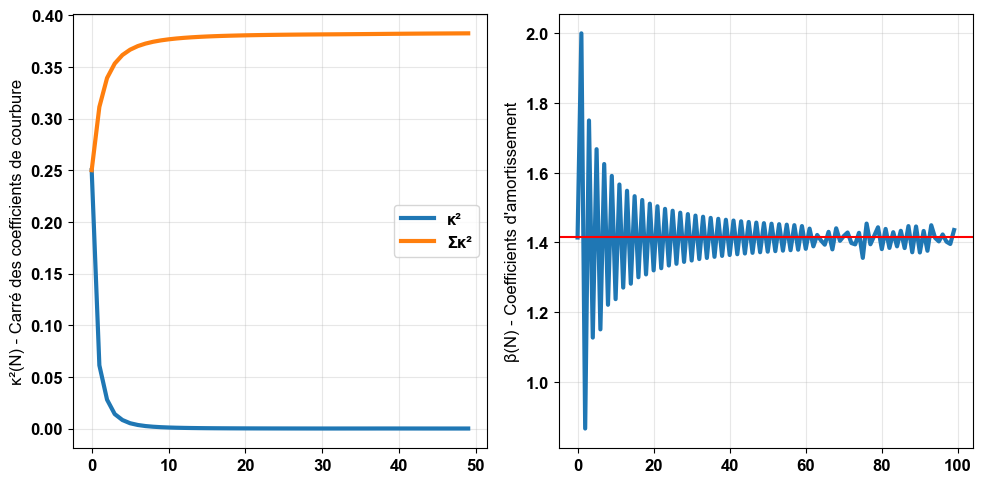

In [7]:
import matplotlib.pyplot as plt
font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

kappas = G.calculate_kappa()

# Préparer les données pour l'analyse
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

kappa_sq = G.kappas**2  # Carré des coefficients kappa
kappas_sum = np.cumsum(kappa_sq)  # Somme cumulative

# Tracer les coefficients kappa et leur somme cumulative
axs[0].plot(G.kappas**2, label='κ²', linewidth=3)
axs[0].set_ylabel('κ²(N) - Carré des coefficients de courbure')
axs[0].plot(kappas_sum, label='Σκ²', linewidth=3)
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Tracer les coefficients bêta
axs[1].plot(G.betas, linewidth=3)
axs[1].axhline(y=G.betas.mean(), color='r', linestyle='-')
axs[1].set_ylabel('β(N) - Coefficients d\'amortissement')
axs[1].grid(True, alpha=0.3)

print("Average beta: ",G.betas.mean())

plt.tight_layout()
plt.show()

## Étape 6 : Analyse des Résistances Effectives et Densités de Probabilité

Calculer les résistances effectives du système et comparer avec les carrés de la fonction d'onde.

Résistance effective : 0.3824


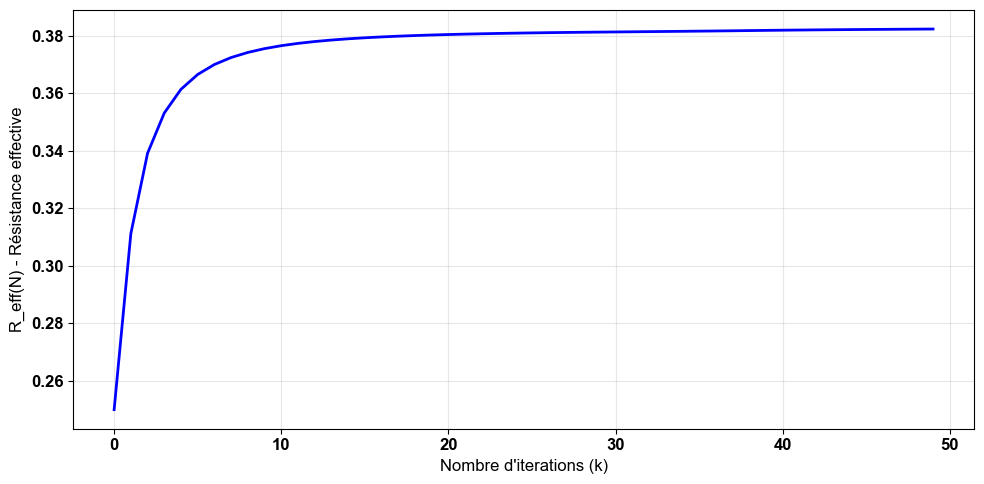

In [8]:
import matplotlib.pyplot as plt

# Calculer les résistances effectives et carrés de la fonction d'onde
psi_squareds = G.psi_approx_squared()
resistances_eff = G.calculate_effective_resistances()

# Afficher la résistance effective moyenne
print(f"Résistance effective : {np.mean(resistances_eff[-1]):.4f}")

# Créer deux graphiques comparatifs
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Graphique 1 : Résistances effectives
axs.plot(resistances_eff, 'b-', linewidth=2)
axs.set_ylabel('R_eff(N) - Résistance effective')
axs.set_xlabel('Nombre d\'iterations (k)')
axs.grid(True, alpha=0.3)

""" # Graphique 2 : Densité de probabilité (ψ²)
axs[1].plot(psi_squareds, 'r-', linewidth=2)
axs[1].set_ylabel('|ψ(N)|² - Densité de probabilité')
axs[1].set_xlabel('Nombre d\'iterations (k)')
axs[1].grid(True, alpha=0.3) """

plt.tight_layout()
plt.show()

## Étape 7 : Recherche du Chemin le Plus Court via Pondération Quantique

Utiliser les poids quantiques pour identifier le chemin optimal du point d'entrée au point de sortie. Le chemin suit les arêtes avec les poids quantiques les plus élevés.

In [9]:
import math
import copy

# Copie profonde du graphe pour l'analyse du chemin
shortest_path_graph = copy.deepcopy(G)

def find_the_shortest_path(G, ix, iy):
    """
    Trouve le chemin le plus court du point d'entrée au point de sortie en utilisant les poids quantiques.
    """
    next_node = f"N_{ix}_{iy}"
    exit_node = f"N_{ex}_{ey}"
    shortest_path = [next_node]
    max_adj_node = 0
    
    while next_node != exit_node:
        for adj in G.adj[next_node]:
            if adj in shortest_path:
                continue
            w = G.nodes[adj]["weight"]
            if G.nodes[adj]["type"] == "node":
                next_node = adj
            elif abs(w) > max_adj_node:
                next_node = adj
                max_adj_node = abs(w)
        max_adj_node = 0
        shortest_path.append(next_node)
    
    # Marquer les nœuds du chemin (poids = 1) et les autres (poids = 0)
    for node in G.nodes():
        G.nodes[node]['weight'] = 1 if node in shortest_path else 0
    
    return shortest_path

# Afficher le chemin trouvé
path = find_the_shortest_path(shortest_path_graph, ix, iy)
print(f"Chemin quantique optimal: {len([n for n in path if n.startswith('N_')])} bus nodes")

# Plotly visualization with scientific styling
fig = plot_shortest_path_plotly(G, path, psi_dict=psi_approx, node_size=10, colorscale='Plasma')
fig.show()

Chemin quantique optimal: 3 bus nodes


## Étape 8 : Visualisation Radar de la Fonction d'Onde

Créer un diagramme radar pour visualiser l'évolution de la fonction d'onde ψ à travers toutes les étapes de propagation pour un nœud ou une arête spécifique.

In [10]:
import plotly.graph_objects as go

def plot_node_radar(G):
    """
    Crée un diagramme radar des composantes ψ pour un nœud ou une arête spécifique.
    
    Paramètres :
    -----------
    G : HamiltonianGrid
        L'objet grille quantique
    target_node : str
        L'identifiant du nœud ou de l'arête à inspecter
        
    Retour :
    --------
    Affiche une figure Plotly interactive
    """
    # Créer les catégories pour chaque étape
    categories = [f"L_{i+1}" for i in range(len(G._lines))]
    
    # Récupérer les valeurs ψ pour chaque étape
    values = [G.psis[-1].get(G._lines[i], 0) for i in range(len(G._lines))]
    
    # Fermer la boucle pour le diagramme radar
    categories_closed = categories + [categories[0]]
    values_closed = values + [values[0]]

    fig = go.Figure()

    # Ajouter la trace ψ
    fig.add_trace(go.Scatterpolar(
        r=values_closed,
        theta=categories_closed,
        fill='toself',
        name=f'Nœud de ligne',
        line_color='cyan'
    ))

    # Configurer la mise en page
    fig.update_layout(
        polar=dict(
            angularaxis=dict(
            tickfont_size=12, # Taille des étiquettes des lignes
            rotation=90,      # Oriente le graphique
        ),
            radialaxis=dict(
                visible=True, 
                range=[min(values)-0.1, max(values)+0.1]
            )
        ),
        #margin=dict(l=80, r=80, t=100, b=80),
        showlegend=True,
        title=f"Profil Quantique ψ: Nœud de ligne",
        template="plotly_dark",
        width=1500,
        height=1000
    )

    fig.show()

# Afficher le profil quantique pour l'arête d'entrée
plot_node_radar(G)